<a href="https://colab.research.google.com/github/qazalmehrban/Medical-Segmentation/blob/ghazal/Unet_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from skimage.transform import resize
import numpy as np
import nibabel as nib
import os 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
samples = '/content/drive/MyDrive/samples/'
labels = '/content/drive/MyDrive/segmentation/'
#patients = next(os.walk(samples))[2]

#segmentations =next(os.walk(labels))[2]


In [21]:
patients_object = os.scandir(samples)
patients_list = [i.path for i in patients_object]
patients_list.sort()

segment_object = os.scandir(labels)
segment_list = [i.path for i in segment_object]
segment_list.sort()










In [ ]:
def description(samples):
  unique_spational = set()
  all_spational_slice = []
  patients = os.listdir(samples)
  patients.sort()
  for number_file, image_id  in enumerate(patients):
    im = nib.load(os.path.join(samples, image_id))    
    im = np.array(im.dataobj)
    unique_spational.add(im.shape[:2])
    for slices in range(im.shape[2]):

      all_spational_slice.append(im.shape[:2])
  print(f"there are {len(unique_spational)} unique spational dimension")
  print(f"there are {number_file} patient image")
  for i in unique_spational:
   print(f'there are {all_spational_slice.count(i)} slice with shape {i}')


In [ ]:
description(samples)

In [ ]:
def description_mask(labels):
  segmentations = os.listdir(labels)
  segmentations.sort()

  k = set()
  num = []
  for i1 in segmentations:
    
    Masks = nib.load(os.path.join(labels, i1))    
    Masks = np.array(Masks.dataobj)
    for  j in range(Masks.shape[2]):
      u = np.unique(Masks[:,:,j])
      u = tuple(u.astype(np.int))
      k.add(u)
      num.append(u)
  for i in k :
    print(f'there are {num.count(i)} slice with label {i}')



In [ ]:
description_mask(labels)

In [22]:
def make_box(mask):
    box = []
    box_bool=[]
    obj_ids = np.unique(mask)
    if mask.dtype == bool:
        if len(np.unique(mask))==2:
            
            y_min = np.nonzero(mask)[0].min()
            y_max = np.nonzero(mask)[0].max()
            x_min = np.nonzero(mask)[1].min()
            x_max = np.nonzero(mask)[1].max()
            box=[x_min, y_min, x_max, y_max]
    else :
        mask_bool = mask.astype(np.bool)
        if len(np.unique(mask_bool))==2:
            
            y_min = np.nonzero(mask_bool)[0].min()
            y_max = np.nonzero(mask_bool)[0].max()
            x_min = np.nonzero(mask_bool)[1].min()
            x_max = np.nonzero(mask_bool)[1].max()
            box_bool=[x_min, y_min, x_max, y_max]
        
        for i in  obj_ids[1:]:
            y_min = np.nonzero(mask==i)[0].min()
            y_max = np.nonzero(mask==i)[0].max()
            x_min = np.nonzero(mask==i)[1].min()
            x_max = np.nonzero(mask==i)[1].max()
            box.append([x_min, y_min, x_max, y_max])
    return_object = box if mask.dtype ==bool else (dict(zip([f"label{int(i)}" for i in obj_ids[1:]],box)), box_bool)
    return return_object

In [ ]:
Masks = nib.load((labels + segmentations[0]))    
Masks = np.array(Masks.dataobj)
print('shape', Masks.shape)
slices =7
Masks_2d = Masks[:,:,slices]
print(f'labels_slice_{slices}', np.unique(Masks_2d))
print('bounding_box', make_box(Masks_2d.astype(bool)))
plt.imshow(Masks_2d)

In [ ]:
Masks = nib.load((labels + segmentations[0]))    
Masks = np.array(Masks.dataobj)
print('shape', Masks.shape)
slices =1
Masks_2d = Masks[:,:,slices]
print(f'labels_slice_{slices}', np.unique(Masks_2d))
print('bounding_box', make_box(Masks_2d))
plt.imshow(Masks_2d)

In [23]:
def crop_specific(im, mask, crop_size):
        
        k=make_box(mask.astype(np.bool))
        if len(k)!=0:
            b_list = k
            x_min, y_min, x_max, y_max = b_list
            
            length_x = x_max -x_min + 1
            length_y = y_max - y_min + 1
            del_x = crop_size - length_x 
            del_y = crop_size - length_y 

            if del_x%2==0:
                kx = del_x//2
                sx=0
            else:
                kx = del_x//2

                sx = 1
            if del_y%2==0:
                ky = del_y//2
                sy=0
            else:
                ky = del_y//2
                sy = 1
            
            crop = mask[ y_min - ky - sy : y_max + ky + 1, x_min - kx - sx : x_max + kx  + 1]
            crop_im = im[ y_min - ky - sy : y_max + ky + 1, x_min - kx - sx : x_max + kx  + 1]
            return crop_im, crop, 


In [24]:
len(segment_list)

53

In [25]:
crop_size = 192
p_seg = []
p_im = []
for patient_file, segment_file in zip( patients_list[:40], segment_list[:40]):
    im = nib.load(patient_file)    
    im = np.array(im.dataobj)

    Masks = nib.load(segment_file)    
    Masks = np.array(Masks.dataobj)
    Masks.shape
    for  j in range(Masks.shape[2]):
      k=make_box(Masks[:,:,j].astype(np.bool))
      if len(k)!=0:
        crop_im , crop = crop_specific(im[:,:,j], Masks[:,:,j], crop_size= crop_size)
        p_seg.append(crop)
        p_im.append(crop_im)


    
   

In [26]:
crop_size = 192
p_seg_t = []
p_im_t = []
for patient_file, segment_file in zip( patients_list[40:], segment_list[40:]):
    im = nib.load(patient_file)    
    im = np.array(im.dataobj)

    Masks = nib.load(segment_file)    
    Masks = np.array(Masks.dataobj)
    Masks.shape
    for  j in range(Masks.shape[2]):
      k=make_box(Masks[:,:,j].astype(np.bool))
      if len(k)!=0:
        crop_im , crop = crop_specific(im[:,:,j], Masks[:,:,j], crop_size= crop_size)
        p_seg_t.append(crop)
        p_im_t.append(crop_im)



In [27]:
segment_numpy = np.stack(p_seg,2)
image_numpy = np.stack(p_im, 2)

segment_numpy_t = np.stack(p_seg_t,2)
image_numpy_t = np.stack(p_im_t, 2)

In [28]:
train = image_numpy/image_numpy.max()
test = image_numpy_t/image_numpy.max()

In [29]:
train_image  = np.transpose(train,(2,0,1))
test_image  = np.transpose(test,(2,0,1))

In [30]:
train_seg = np.transpose(segment_numpy,(2,0,1))
test_seg = np.transpose(segment_numpy_t,(2,0,1))

In [31]:
train_seg_bolean = train_seg.astype(bool)
test_seg_bolean = test_seg.astype(bool)

In [65]:
train_seg_f = train_seg_bolean.astype(np.dtype('float32'))
test_seg_f = test_seg_bolean.astype(float)

In [69]:
test_seg_f = np.float32(train_seg_f)
train_image = np.float32(train_image)

In [68]:
test_seg_f.dtype

dtype('float32')

# Pytorch

In [70]:
train_image_torch = np.expand_dims(train_image,1)
train_seg_torch  = np.expand_dims(train_seg_f,1)

In [34]:
train_image_torch.shape

(556, 1, 192, 192)

In [35]:
def conv1x1_bn_relu(inp_activation, output_activation, BN=True, activation = True):
    "con 1x1 + Batchnormalization + relu"
    layer = [nn.Conv2d(inp_activation, output_activation, 1)]
    for i, j in zip([nn.BatchNorm2d(output_activation), nn.ReLU(inplace=True)],[BN, activation]):
        if j==True:
            layer.append(i)
    return nn.Sequential(*layer)

In [36]:
def conv3x3_bn_relu(inp_activation, output_activation, BN=True, activation = True):
    "con 3x3 + Batchnormalization + relu"
    layer = [nn.Conv2d(inp_activation, output_activation, 3, padding = 1)]
    for i, j in zip([nn.BatchNorm2d(output_activation), nn.ReLU(inplace=True)],[BN, activation]):
        if j==True:
            layer.append(i)
    return nn.Sequential(*layer)

In [37]:
class bottleneck_block(nn.Module):
    
    def __init__(self, input_activation, list_filter=[256, 64, 256], down = None):
        super().__init__()
        self.conv1x1_1 = conv1x1_bn_relu(input_activation, list_filter[0])
        self.conv3x3 = conv3x3_bn_relu(list_filter[0], list_filter[1])
        self.conv1x1_2 = conv1x1_bn_relu(list_filter[1], list_filter[2])
        self.down = down
        if down!=None:
            self.contract_conv = down
    def forward(self , inp):
        x = inp
        c = self.conv1x1_1(inp)
        c = self.conv3x3(c)
        result = self.conv1x1_2(c)
        if self.down!=None:
            x = self.contract_conv(inp)
        
        out = result + x
        
        return out
            


In [38]:
class conv_block(nn.Module):
    
    def __init__(self, inp_activation, list_filter ,resnet_block = False, downsample= None ):
        super().__init__()
        self.conv3x3_1 = conv3x3_bn_relu(inp_activation, list_filter)
        self.conv3x3_2 = conv3x3_bn_relu(list_filter, list_filter)
        self.down = downsample
    def forward(self , inp):
        c = self.conv3x3_1(inp)
        c = self.conv3x3_2(c)
        return c

In [55]:
class Unet_res_b(nn.Module):
    def __init__(self, n_class):
        
        super().__init__()
        self.en_block1 = conv_block(1,32)
        self.en_block2 = conv_block(32,64)
        self.en_block3 = conv_block(64,128)
        self.en_block4 = conv_block(128,256)
        self.en_block5 = conv_block(256,512)
        self.en_block6 = conv_block(512, 1024)

        
        self.transpose5 = nn.ConvTranspose2d(1024,512,2,2)
        self.transpose4 = nn.ConvTranspose2d(512,256,2,2)

        self.transpose3 = nn.ConvTranspose2d(256,128,2,2)
        self.transpose2 = nn.ConvTranspose2d(128,64,2,2)
        self.transpose1 = nn.ConvTranspose2d(64,32,2,2)
        
        self.de_block1 = conv_block(64,32)
        self.de_block2 = conv_block(128,64)
        self.de_block3 = conv_block(256,128)

        self.de_block4 = conv_block(512, 256)
        self.de_block5 = conv_block(1024, 512)
        self.out_conv = nn.Conv2d(32, 1, 1)

        
    

    def forward(self, inp):
        el1 = self.en_block1(inp) #  (32,h,w)
        max1 = nn.MaxPool2d(2)(el1) # (32,h//2, w//2)

        el2 = self.en_block2(max1)    #(64, h//2, w//2)
        max2 = nn.MaxPool2d(2)(el2)  #(64, h//4, w//4)

        el3 = self.en_block3(max2)    #(128, h//4, w//4)
        max3 = nn.MaxPool2d(2)(el3)  #(128, h//8, w//8)

        el4 = self.en_block4(max3)    #(256, h//8, w//8)
        max4 = nn.MaxPool2d(2)(el4)  #(256, h//16, w//16)
        
        el5 = self.en_block5(max4)  #(512, h//16, w//16)
        max5 = nn.MaxPool2d(2)(el5)  #(512, h//32, w//32)
        
        el6 = self.en_block6(max5)  #(1024, h//32, w//32)

        el5 = self.transpose5(el6)  #(512, h//16, w//16)
        cat5 = torch.cat([el5, el5], 1) #(1024, h//16, h//16 )
        d5 =  self.de_block5(cat5)      #(512, h//16, w//16)
        
        tl4 = self.transpose4(d5)       #(256, h//8, w//8)
        cat4 = torch.cat([tl4, el4], 1) #(512, h//8, w//8)
        d4 =  self.de_block4(cat4)     #(256, h//8, w//8)
        
        tl3 = self.transpose3(d4)        #(128, h//4, w//4)
        cat3 = torch.cat([tl3, el3], 1)  #(256, h//4, w//4)
        d3 =  self.de_block3(cat3)        #(128, h//4, w//4)
        
        
        tl2 = self.transpose2(d3)          #(64, h//2, w//2)
        cat2 = torch.cat([tl2, el2], 1)   #(128, h//2, w//2)
        d2 =  self.de_block2(cat2)         #(64, h//2, w//2)
        
        tl1 = self.transpose1(d2)          #(32, h, w)
        cat1 = torch.cat([tl1, el1], 1) #(64, h, w)
        d1 =  self.de_block1(cat1)        #(32, h, w)
        output = self.out_conv(d1) 

        return output



In [56]:
m = Unet_res_b(2)

In [57]:
m.to(torch.device('cuda'))

Unet_res_b(
  (en_block1): conv_block(
    (conv3x3_1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv3x3_2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (en_block2): conv_block(
    (conv3x3_1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv3x3_2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )

In [ ]:
m(torch.tensor(train_image_torch)[:3]).shape

torch.Size([3, 2, 192, 192])

In [71]:
d_tr = torch.utils.data.DataLoader(train_image_torch,32)
d_seg = torch.utils.data.DataLoader(train_seg_torch,32)

In [48]:
device = torch.device('cuda')

In [49]:
opt = torch.optim.Adam(m.parameters())

In [50]:
loss = torch.nn.BCELoss()

In [75]:
im = im.to(device=device)


RuntimeError: ignored

In [74]:
for im , segi in zip(d_tr, d_seg):
  im = im.to(device=device)
  segi =segi.to(device)
  yh = m(im)
  l = loss(yh, segi)
  #print(l)
  opt.zero_grad()
  l.backward()
  opt.step
  

RuntimeError: ignored

# Model

In [ ]:
img_size = (crop_size, crop_size)

In [ ]:


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, 3)
model.summary()

# train

In [ ]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("unet_seg.h5", save_best_only=True)
]

epochs = 50
model.fit(tra, seg, epochs=epochs, batch_size=32)

In [ ]:

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


In [ ]:

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

pr = model.predict(tra[:670])

In [ ]:
pr.shape

In [ ]:
mask1 = np.argmax(pr[46], axis=-1)
plt.imshow(mask1)


In [ ]:
plt.imshow(seg_f[46])

In [ ]:
np.unique(seg_f[46])

In [ ]:
plt.imshow(seg[46])

In [ ]:
pr[2]

# Traditional Unet

In [ ]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 192, 192, 1


In [ ]:
from tensorflow.keras import layers

# Croos entropy loss

In [ ]:
def U_Net_Segmentation(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    
    inputs = tf.keras.Input(input_size)
    
    
    c1 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)


    c2 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)


    c3 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)


    c4 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)


    c5 = layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c5)



    u6 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c6)   


    u7 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c7) 

    u8 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c8) 
    
    
    u9 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis = 3)
    c9 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c9) 
    
    outputs = layers.Conv2D(2,(1,1), activation="softmax",)(c9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    
    model.summary()
    return model

In [ ]:
def Dice(y_true, y_pred):

    
    
  mask1 = tf.math.argmax(y_pred, axis=-1)

  y_pred= tf.cast(mask1, tf.float32)
  inter = tf.reduce_sum(y_pred * y_true, [1,2])
  uni = tf.reduce_sum(y_pred , [1,2])+ tf.reduce_sum( y_true, [1,2])

  des = tf.reduce_mean(2*inter/uni)
       
  return des

model = U_Net_Segmentation()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 192, 192, 1) 0                                            
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 192, 192, 16) 160         input_5[0][0]                    
__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 192, 192, 16) 0           conv2d_76[0][0]                  
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 192, 192, 16) 2320        dropout_36[0][0]                 
____________________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam()


In [ ]:
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[Dice])
                 

In [ ]:
results = model.fit(train_image, train_seg_f,
                    shuffle = True,
              validation_split = 0.1,
                    batch_size=32,
                    epochs=70)

Epoch 1/70
18/18 [==============================] - 8s 354ms/step - loss: 0.5936 - Dice: 0.0686 - val_loss: 0.4378 - val_Dice: 0.0000e+00
Epoch 2/70
18/18 [==============================] - 6s 328ms/step - loss: 0.3982 - Dice: 0.0000e+00 - val_loss: 0.3868 - val_Dice: 0.0000e+00
Epoch 3/70
18/18 [==============================] - 6s 327ms/step - loss: 0.2998 - Dice: 5.1573e-07 - val_loss: 0.2416 - val_Dice: 0.0000e+00
Epoch 4/70
18/18 [==============================] - 6s 329ms/step - loss: 0.2522 - Dice: 9.2927e-06 - val_loss: 0.2739 - val_Dice: 0.0000e+00
Epoch 5/70
18/18 [==============================] - 6s 327ms/step - loss: 0.2270 - Dice: 1.5107e-04 - val_loss: 0.2952 - val_Dice: 0.0000e+00
Epoch 6/70
18/18 [==============================] - 6s 327ms/step - loss: 0.2326 - Dice: 0.0042 - val_loss: 0.2438 - val_Dice: 1.6249e-04
Epoch 7/70
18/18 [==============================] - 6s 327ms/step - loss: 0.2118 - Dice: 0.0592 - val_loss: 0.2006 - val_Dice: 0.6931
Epoch 8/70
18/18 [====

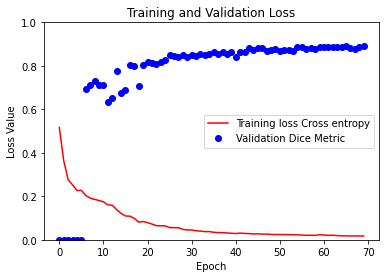

In [ ]:
loss = results.history['loss']
val_loss = results.history['val_Dice']

epochs = range(70)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss Cross entropy')
plt.plot(epochs, val_loss, 'bo', label='Validation Dice Metric')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

pr = model.predict(test_image[:7])

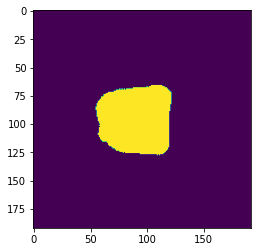

In [ ]:
mask1 = np.argmax(pr[2], axis=-1)
plt.imshow(mask1)


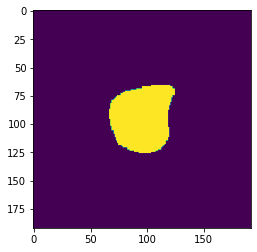

In [ ]:
plt.imshow(test_seg_f[2])


# Dice loss

In [ ]:
def U_Net_Segmentation(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    
    inputs = tf.keras.Input(input_size)
    
    
    c1 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)


    c2 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)


    c3 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)


    c4 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)


    c5 = layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c5)



    u6 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c6)   


    u7 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c7) 

    u8 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c8) 
    
    
    u9 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis = 3)
    c9 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c9) 
    
    outputs = layers.Conv2D(1,(1,1), activation="softmax",)(c9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    
    model.summary()
    return model

In [ ]:
model = U_Net_Segmentation()

In [ ]:
def dice_loss(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator/ denominator

In [ ]:
optimizer = tf.keras.optimizers.Adam()


In [ ]:
model.compile(optimizer=optimizer, loss=dice_loss
                 )

In [ ]:
results = model.fit(tra, seg,
                    shuffle = False, 
                    validation_split=0.1, 
                    batch_size=32,
                    epochs=50)